# Goals

- The main goal of this project is to make a prediction of stock prices of PETR4.
- Additionally, I would like to work with 2-month predictions in order to figure out a way to find out nice opportunities for options on this stock. PETR4 options are amidst the most traded in the world.
- An extension to this project would be to build a bot to trade this stock.

## How

- First I'm going to make use of time series with the daily stock prices, probably LSTM or bidirectional LSTM, which are the most relevant. 
- Maybe I could try to put another variable like international price of oil or other oil stocks.

# Getting Data

In [1]:
#!pip install yfinance

In [46]:
import yfinance as yf
import pandas as pd

In [3]:
papel = yf.Ticker('PETR4.SA')
papel

yfinance.Ticker object <PETR4.SA>

In [4]:
dados= papel.history(start= '2007-01-01', end='2022-12-29')

In [5]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3966 entries, 2007-01-02 00:00:00-02:00 to 2022-12-28 00:00:00-03:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3966 non-null   float64
 1   High          3966 non-null   float64
 2   Low           3966 non-null   float64
 3   Close         3966 non-null   float64
 4   Volume        3966 non-null   int64  
 5   Dividends     3966 non-null   float64
 6   Stock Splits  3966 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 247.9 KB


# Exploratory Analysis

In [6]:
# Close price through the years

<AxesSubplot:xlabel='Date'>

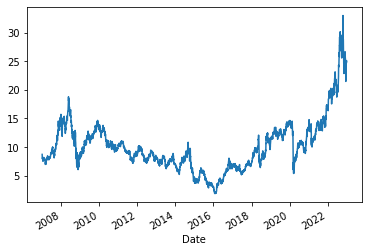

In [7]:
dados['Close'].plot()

In [8]:
# dividend distribution

In [9]:
div=dados[['Dividends']]
div=div[div['Dividends']>0]
div.head()

,Dividends
Date,
2007-01-02 00:00:00-02:00,0.2250
2007-04-03 00:00:00-03:00,0.1750
2007-08-20 00:00:00-03:00,0.2517
2007-10-08 00:00:00-03:00,0.2565
2008-01-14 00:00:00-02:00,0.1553


In [10]:
div.index

DatetimeIndex(['2007-01-02 00:00:00-02:00', '2007-04-03 00:00:00-03:00',
               '2007-08-20 00:00:00-03:00', '2007-10-08 00:00:00-03:00',
               '2008-01-14 00:00:00-02:00', '2008-04-07 00:00:00-03:00',
               '2008-12-29 00:00:00-02:00', '2009-04-09 00:00:00-03:00',
               '2009-07-06 00:00:00-03:00', '2009-10-01 00:00:00-03:00',
               '2009-12-21 00:00:00-02:00', '2010-04-23 00:00:00-03:00',
               '2010-05-24 00:00:00-03:00', '2010-08-02 00:00:00-03:00',
               '2010-11-03 00:00:00-02:00', '2010-12-22 00:00:00-02:00',
               '2011-03-22 00:00:00-03:00', '2011-04-29 00:00:00-03:00',
               '2011-05-12 00:00:00-03:00', '2011-08-03 00:00:00-03:00',
               '2011-11-14 00:00:00-02:00', '2012-01-03 00:00:00-02:00',
               '2012-03-20 00:00:00-03:00', '2012-05-14 00:00:00-03:00',
               '2013-04-30 00:00:00-03:00', '2014-04-03 00:00:00-03:00',
               '2018-05-22 00:00:00-03:00', '2018-0

In [11]:
#for date in div.index:
    #print(date)

In [12]:
div.index[0]

Timestamp('2007-01-02 00:00:00-0200', tz='America/Sao_Paulo')

In [13]:
dados.index.get_loc(div.index[2])

157

In [14]:
dados.index.get_loc('2007-08-20 00:00:00-03:00')

157

In [15]:
dados.iloc[157]

Open            8.221953e+00
High            8.241328e+00
Low             8.031728e+00
Close           8.149738e+00
Volume          2.473800e+07
Dividends       2.517000e-01
Stock Splits    0.000000e+00
Name: 2007-08-20 00:00:00-03:00, dtype: float64

In [16]:
locations_div=[]
for data in div.index:
    locations_div.append(dados.index.get_loc(data))

In [17]:
close_div=[]
for loc in locations_div:
    close_div.append(dados.iloc[loc]['Close'])

In [18]:
div['Price']=close_div

In [19]:
div['DY']=div['Dividends']/div['Price']

In [20]:
div

,Dividends,Price,DY
Date,,,
2007-01-02 00:00:00-02:00,0.225000,8.701066,0.025859
2007-04-03 00:00:00-03:00,0.175000,7.908743,0.022127
2007-08-20 00:00:00-03:00,0.251700,8.149738,0.030884
2007-10-08 00:00:00-03:00,0.256500,10.987374,0.023345
2008-01-14 00:00:00-02:00,0.155300,14.462685,0.010738
2008-04-07 00:00:00-03:00,0.102600,14.037208,0.007309
2008-12-29 00:00:00-02:00,0.042600,8.069037,0.005279
2009-04-09 00:00:00-03:00,0.351600,11.181713,0.031444
2009-07-06 00:00:00-03:00,0.300000,10.998056,0.027278


<AxesSubplot:xlabel='Date'>

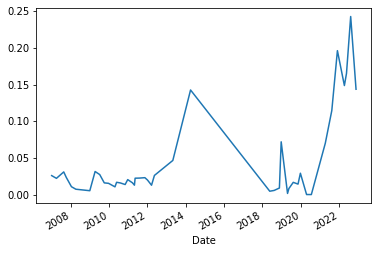

In [21]:
div['DY'].plot()

In [22]:
#!git add .
#!git commit -m 'petro analysis'
#!git push origin main

# Model example

## Previous time series project

- for information, i copied this from a previous rnn project

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Flatten, LSTM
from tensorflow.keras.callbacks import EarlyStopping

def initialize_model():
    model = Sequential()
    model.add(SimpleRNN(units=20,activation='tanh',input_shape=(3966, 1)))
    model.add(Dense(10,activation='tanh'))
    model.add(Dense(1,activation='linear'))
    
    return model

model=initialize_model()
model.summary()

2023-01-07 11:45:48.245432: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-07 11:45:48.245590: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 20)                440       
                                                                 
 dense (Dense)               (None, 10)                210       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 661
Trainable params: 661
Non-trainable params: 0
_________________________________________________________________


2023-01-07 11:45:52.670115: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-07 11:45:52.670992: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-07 11:45:52.671068: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-23E8V41): /proc/driver/nvidia/version does not exist
2023-01-07 11:45:52.675094: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
'''
def compile_model(model):
    model.compile(loss='mse',optimizer='rmsprop',metrics=['mae'])
    return model
model=compile_model(model)

model = compile_model(initialize_model())

model.fit(X_train,y_train, batch_size=32, epochs=30,verbose=1,validation_split=0.2,
          callbacks=[EarlyStopping(patience=5,restore_best_weights=True)]
)
'''

"\ndef compile_model(model):\n    model.compile(loss='mse',optimizer='rmsprop',metrics=['mae'])\n    return model\nmodel=compile_model(model)\n\nmodel = compile_model(initialize_model())\n\nmodel.fit(X_train,y_train, batch_size=32, epochs=30,verbose=1,validation_split=0.2,\n          callbacks=[EarlyStopping(patience=5,restore_best_weights=True)]\n)\n"

## LSTM for stocks

- Found this on the internet. Very good base example of a LSTM stock prediction.

In [25]:
#https://medium.com/the-handbook-of-coding-in-finance/stock-prices-prediction-using-long-short-term-memory-lstm-model-in-python-734dd1ed6827

In [26]:
import math
from sklearn.preprocessing import MinMaxScaler 
import numpy as np

close_prices = dados['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]


#train set

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

#test set
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [27]:
#model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 25)                2525      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 32, epochs=3)

Epoch 1/3
98/98 [==============================] - 17s 126ms/step - loss: 0.0021
Epoch 2/3
98/98 [==============================] - 12s 123ms/step - loss: 2.7993e-04
Epoch 3/3
98/98 [==============================] - 12s 123ms/step - loss: 2.5422e-04


In [29]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.1756327131206421

/tmp/ipykernel_6047/2686380006.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


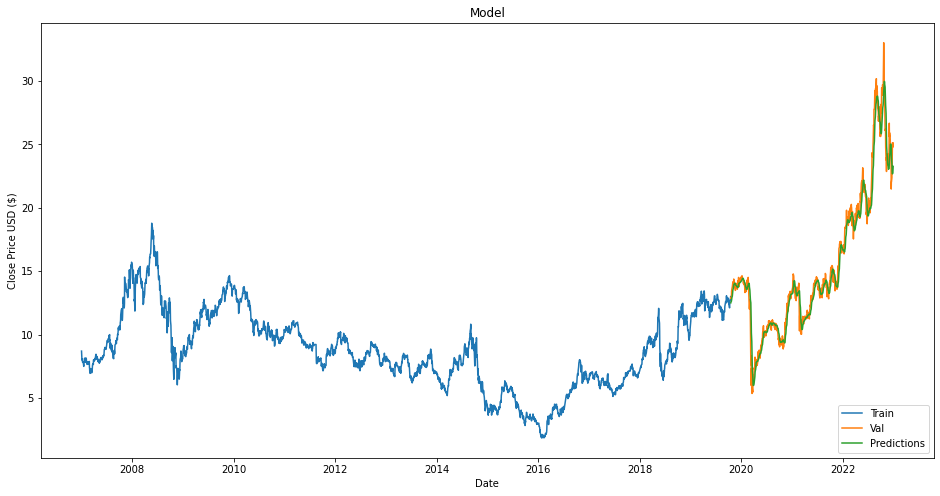

In [30]:
import matplotlib.pyplot as plt

data = dados.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

/tmp/ipykernel_6047/1626216995.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


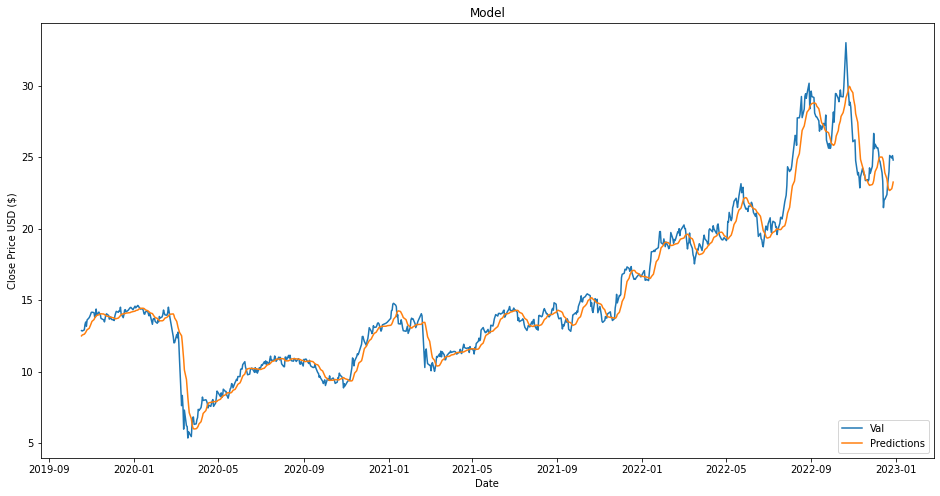

In [31]:
data = dados.filter(['Close'])
#train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
#plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

In [32]:
#there is something wrong in here. There is no way it predicts with this much accuracy data it has never seen.
#there is data leakage somewhere

In [33]:
#um cara falou que da merda no scaling. Usar scaling só com x train

In [34]:
#ele também só preve a proxima data, eu quero prever mais coisas, tipo 1 semana ou a data de 60 dias

# Fixing Data leaking

In [35]:
import math
from sklearn.preprocessing import MinMaxScaler 
import numpy as np

close_prices = dados['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

values=values.reshape(-1,1)
train_values=values[0: training_data_len]

scaler = MinMaxScaler(feature_range=(0,1))
train_data = scaler.fit_transform(train_values)

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [36]:
test_values=values[training_data_len-60:]

test_data = scaler.transform(test_values)
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [37]:
x_test.shape

(793, 60, 1)

In [38]:
y_test.shape

(793, 1)

In [39]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 32, epochs=3)

Epoch 1/3
98/98 [==============================] - 16s 124ms/step - loss: 0.0081
Epoch 2/3
98/98 [==============================] - 12s 124ms/step - loss: 9.0820e-04
Epoch 3/3
98/98 [==============================] - 12s 123ms/step - loss: 8.4410e-04


In [40]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.39161999619473126

/tmp/ipykernel_6047/4044787029.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


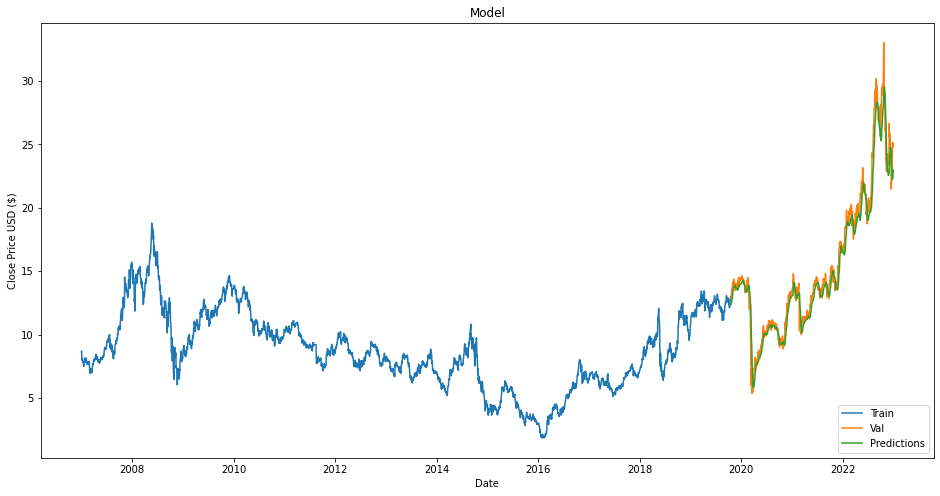

In [41]:
data = dados.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

/tmp/ipykernel_6047/1626216995.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


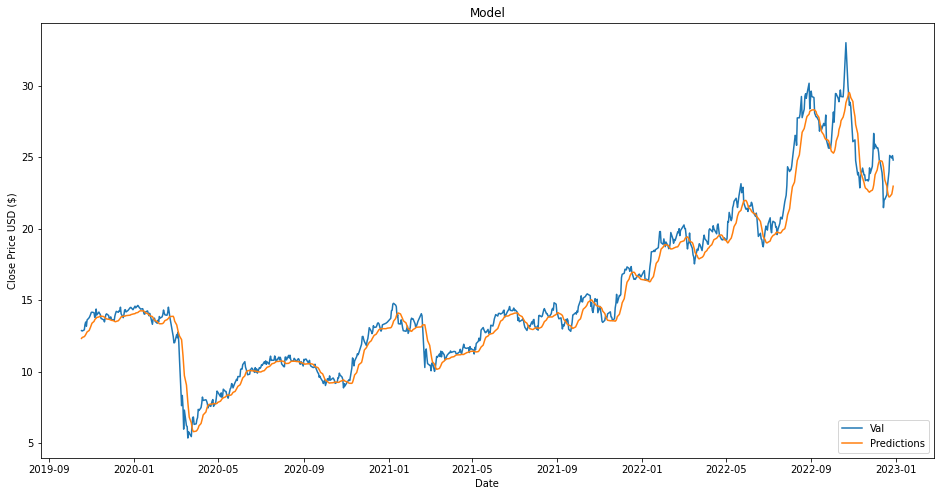

In [42]:
data = dados.filter(['Close'])
#train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
#plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

In [43]:
#looks the same to me. But I'd say its better to not leak data.

In [44]:
#!git add .
#!git commit -m 'first lstm pred'
#!git push origin main

# Baseline model

- I've figured out how to start building up a model with LSTM
- Now, let's find a baseline to compare how good this actually is
- An idea of baseline is to say that the price on d+1 is going to be the same price on d+0

In [47]:
baseline = pd.DataFrame(y_test).rename(columns={0:'d+0'})
baseline

,d+0
0,12.872649
1,12.844728
2,12.923844
3,13.296154
4,13.473001
...,...
788,23.990000
789,25.120001
790,24.940001
791,25.110001


In [48]:
baseline['d-1']=pd.DataFrame(dados['Close'].values[-794:-1])

In [49]:
baseline

,d+0,d-1
0,12.872649,12.998305
1,12.844728,12.872649
2,12.923844,12.844728
3,13.296154,12.923844
4,13.473001,13.296154
...,...,...
788,23.990000,23.570000
789,25.120001,23.990000
790,24.940001,25.120001
791,25.110001,24.940001


## calculate metrics to beat

In [50]:
rmse_base = np.sqrt(np.mean((baseline['d+0']-baseline['d-1'])**2))
rmse_base

0.4619845856279209

In [ ]:
#!git add .
#!git commit -m 'baseline'
#!git push origin main

# Tuning the model

In [52]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train,y_train, batch_size=32, epochs=30,verbose=1,validation_split=0.2,
          callbacks=[EarlyStopping(patience=5,restore_best_weights=True)])

Epoch 1/30
78/78 [==============================] - 20s 187ms/step - loss: 0.0118 - val_loss: 0.0011
Epoch 2/30
78/78 [==============================] - 11s 140ms/step - loss: 9.2286e-04 - val_loss: 9.8158e-04
Epoch 3/30
78/78 [==============================] - 10s 131ms/step - loss: 8.4345e-04 - val_loss: 8.9050e-04
Epoch 4/30
78/78 [==============================] - 10s 129ms/step - loss: 7.4385e-04 - val_loss: 7.7596e-04
Epoch 5/30
78/78 [==============================] - 10s 132ms/step - loss: 7.6381e-04 - val_loss: 8.0452e-04
Epoch 6/30
78/78 [==============================] - 10s 129ms/step - loss: 6.8358e-04 - val_loss: 6.4221e-04
Epoch 7/30
78/78 [==============================] - 10s 133ms/step - loss: 6.4111e-04 - val_loss: 6.1409e-04
Epoch 8/30
78/78 [==============================] - 10s 131ms/step - loss: 5.8217e-04 - val_loss: 5.6382e-04
Epoch 9/30
78/78 [==============================] - 10s 130ms/step - loss: 5.8851e-04 - val_loss: 6.2490e-04
Epoch 10/30
78/78 [========

In [53]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.35588165249529885

In [54]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train,y_train, batch_size=32, epochs=100,verbose=1,validation_split=0.2,
          callbacks=[EarlyStopping(patience=5,restore_best_weights=True)])

Epoch 1/100
78/78 [==============================] - 15s 144ms/step - loss: 0.0089 - val_loss: 0.0014
Epoch 2/100
78/78 [==============================] - 10s 129ms/step - loss: 8.8703e-04 - val_loss: 0.0010
Epoch 3/100
78/78 [==============================] - 10s 129ms/step - loss: 8.5167e-04 - val_loss: 9.0434e-04
Epoch 4/100
78/78 [==============================] - 11s 138ms/step - loss: 7.8797e-04 - val_loss: 9.0318e-04
Epoch 5/100
78/78 [==============================] - 10s 131ms/step - loss: 7.2772e-04 - val_loss: 7.4551e-04
Epoch 6/100
78/78 [==============================] - 10s 131ms/step - loss: 6.3948e-04 - val_loss: 7.5316e-04
Epoch 7/100
78/78 [==============================] - 10s 130ms/step - loss: 6.7882e-04 - val_loss: 6.0381e-04
Epoch 8/100
78/78 [==============================] - 10s 130ms/step - loss: 5.8213e-04 - val_loss: 5.6239e-04
Epoch 9/100
78/78 [==============================] - 10s 131ms/step - loss: 5.4426e-04 - val_loss: 5.0237e-04
Epoch 10/100
78/78 [==

In [55]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.11015652648136866

In [56]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train,y_train, batch_size=16, epochs=30,verbose=1,validation_split=0.2,
          callbacks=[EarlyStopping(patience=5,restore_best_weights=True)])

Epoch 1/30
156/156 [==============================] - 22s 114ms/step - loss: 0.0042 - val_loss: 9.1746e-04
Epoch 2/30
156/156 [==============================] - 17s 107ms/step - loss: 8.2186e-04 - val_loss: 0.0012
Epoch 3/30
156/156 [==============================] - 17s 108ms/step - loss: 8.4441e-04 - val_loss: 6.1654e-04
Epoch 4/30
156/156 [==============================] - 17s 107ms/step - loss: 6.5513e-04 - val_loss: 5.4560e-04
Epoch 5/30
156/156 [==============================] - 17s 107ms/step - loss: 5.9395e-04 - val_loss: 5.2214e-04
Epoch 6/30
156/156 [==============================] - 17s 106ms/step - loss: 5.2290e-04 - val_loss: 5.4951e-04
Epoch 7/30
156/156 [==============================] - 17s 108ms/step - loss: 4.7423e-04 - val_loss: 7.7003e-04
Epoch 8/30
156/156 [==============================] - 17s 107ms/step - loss: 5.4118e-04 - val_loss: 3.5692e-04
Epoch 9/30
156/156 [==============================] - 17s 107ms/step - loss: 3.8944e-04 - val_loss: 3.1891e-04
Epoch 10/

In [57]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.12226908384325526

In [58]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train,y_train, batch_size=16, epochs=100,verbose=1,validation_split=0.2,
          callbacks=[EarlyStopping(patience=5,restore_best_weights=True)])

Epoch 1/100
156/156 [==============================] - 22s 114ms/step - loss: 0.0035 - val_loss: 9.6660e-04
Epoch 2/100
156/156 [==============================] - 18s 112ms/step - loss: 7.9170e-04 - val_loss: 9.0532e-04
Epoch 3/100
156/156 [==============================] - 19s 123ms/step - loss: 7.4837e-04 - val_loss: 6.4763e-04
Epoch 4/100
156/156 [==============================] - 19s 121ms/step - loss: 6.3662e-04 - val_loss: 5.7859e-04
Epoch 5/100
156/156 [==============================] - 18s 116ms/step - loss: 5.6581e-04 - val_loss: 5.1784e-04
Epoch 6/100
156/156 [==============================] - 19s 121ms/step - loss: 5.4209e-04 - val_loss: 6.3697e-04
Epoch 7/100
156/156 [==============================] - 18s 118ms/step - loss: 4.8668e-04 - val_loss: 4.6295e-04
Epoch 8/100
156/156 [==============================] - 17s 109ms/step - loss: 4.2824e-04 - val_loss: 4.2506e-04
Epoch 9/100
156/156 [==============================] - 18s 113ms/step - loss: 4.6325e-04 - val_loss: 7.2758e

In [59]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.0003000532393196943

## saving best model

In [ ]:
#saving best model

In [71]:
#import pickle
#filename = 'model1.sav'
#pickle.dump(model, open(filename, 'wb'))

In [64]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
y_pred=loaded_model.predict(x_test)
y_pred=scaler.inverse_transform(y_pred)
rmse = np.sqrt(np.mean(y_pred - y_test)**2)
rmse

0.0003000532393196943

## plotting pred

In [67]:
predict = pd.DataFrame(y_test).rename(columns={0:'actual'})
predict['pred']=pd.DataFrame(y_pred)
predict

,actual,pred
0,12.872649,13.046602
1,12.844728,12.904233
2,12.923844,12.879879
3,13.296154,12.970886
4,13.473001,13.368048
...,...,...
788,23.990000,23.657970
789,25.120001,24.065165
790,24.940001,25.578207
791,25.110001,24.542372


/tmp/ipykernel_6047/4035412964.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = y_pred


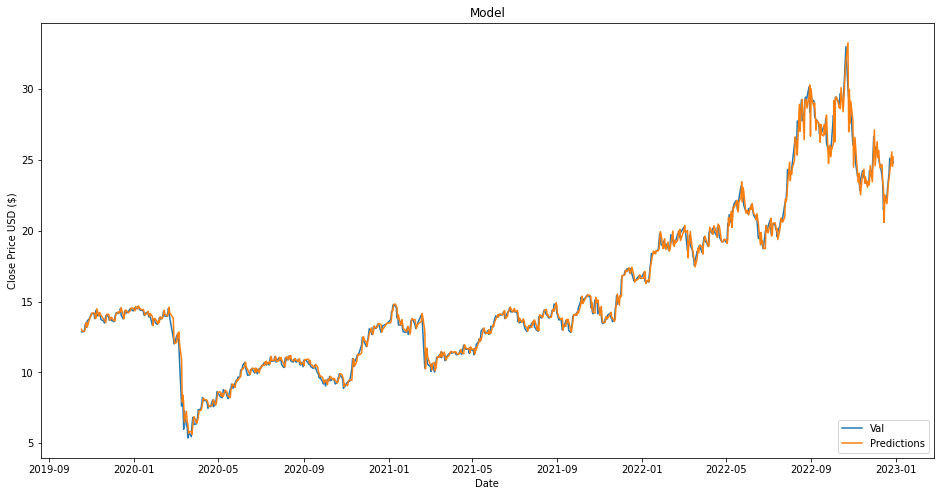

In [68]:
data = dados.filter(['Close'])
#train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = y_pred
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
#plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()